In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


R provides numerous datasets that are accessible through Python

In [2]:
from statsmodels.datasets import get_rdataset

# Access R datasets
ausbeer = get_rdataset('ausbeer', 'fpp2').data


In [3]:
df = pd.read_csv("AUS monthly beer production.csv")
df

,time,value
0,1956.00,284
1,1956.25,213
2,1956.50,227
3,1956.75,308
4,1957.00,262
...,...,...
213,2009.25,398
214,2009.50,419
215,2009.75,488
216,2010.00,414


# Seasonal decomposition

<Figure size 2600x1400 with 0 Axes>

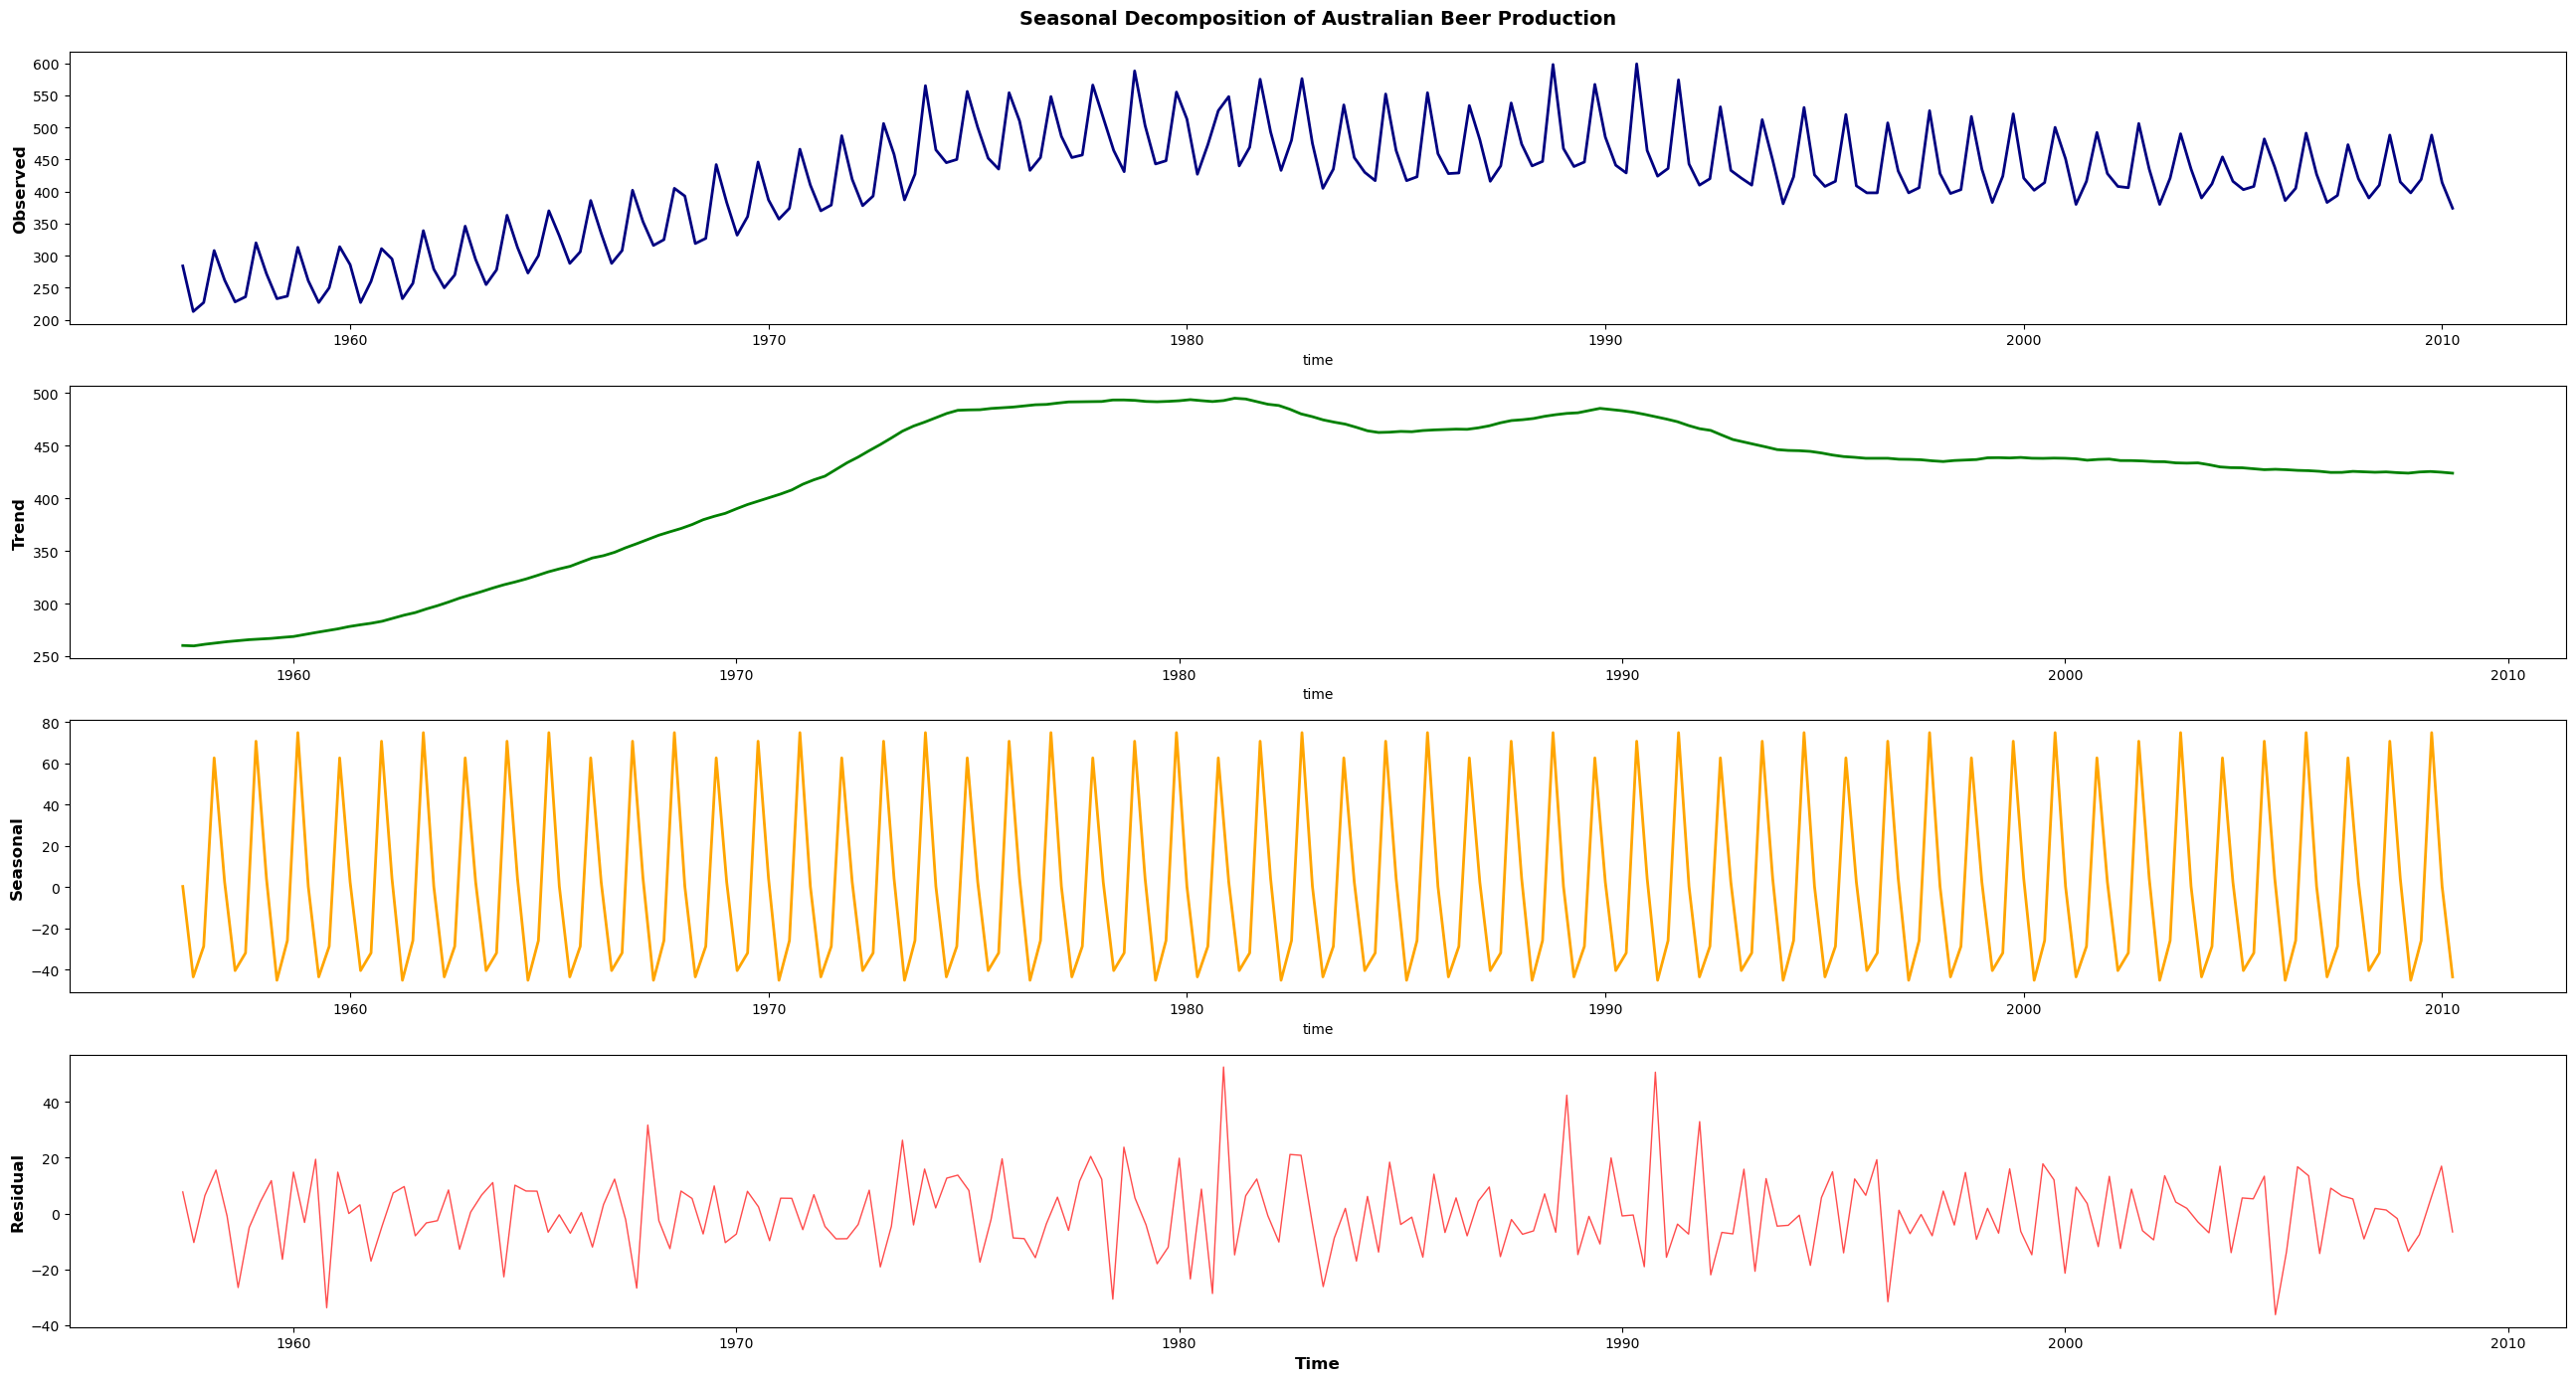

In [4]:
plt.figure(figsize=(26,14))
# set index to "time"
df_indexed = df.set_index('time')

# call decomposition model (seasonal_decompose)
decomposition = seasonal_decompose(df_indexed['value'], 
                                   model='additive', 
                                   period=12)

# Create subplots for better clarity
fig, axes = plt.subplots(4, 1, figsize=(26, 14))

# Original data
decomposition.observed.plot(ax=axes[0], color='navy', linewidth=2)
axes[0].set_ylabel('Observed', fontsize=12, fontweight='bold')
axes[0].set_title('Seasonal Decomposition of Australian Beer Production', fontsize=14, fontweight='bold', pad=20)


# Trend component
decomposition.trend.plot(ax=axes[1], color='green', linewidth=2)
axes[1].set_ylabel('Trend', fontsize=12, fontweight='bold')


# Seasonal component
decomposition.seasonal.plot(ax=axes[2], color='orange', linewidth=2)
axes[2].set_ylabel('Seasonal', fontsize=12, fontweight='bold')


# Residual component
decomposition.resid.plot(ax=axes[3], color='red', linewidth=1, alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Time', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.show()

# autocorrelation (AC) and partial autocorrelation (PAC)  - original data (non-stationary)

The data are quaterly (4 observations per year). So for a good analysis:
16 lags (4quarters * 4 years) or 20 lags (4quarters * 5 years)  
Important is to not exceed: 218/4

If nlags is not specified in the acf --> the standard number is  nlags=24

In [5]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# calculate autocorrelation
acf_values = acf(df.value)
acf_values

array([1.        , 0.68361007, 0.49986057, 0.66666801, 0.93996999,
       0.64390629, 0.45765188, 0.62143982, 0.88738908, 0.59819753,
       0.40993542, 0.57364076, 0.83491233, 0.54268376, 0.35422632,
       0.51852869, 0.76999037, 0.48058745, 0.3002545 , 0.4542808 ,
       0.70365686, 0.41775518, 0.23554345, 0.39325395])

<Figure size 1800x1200 with 0 Axes>

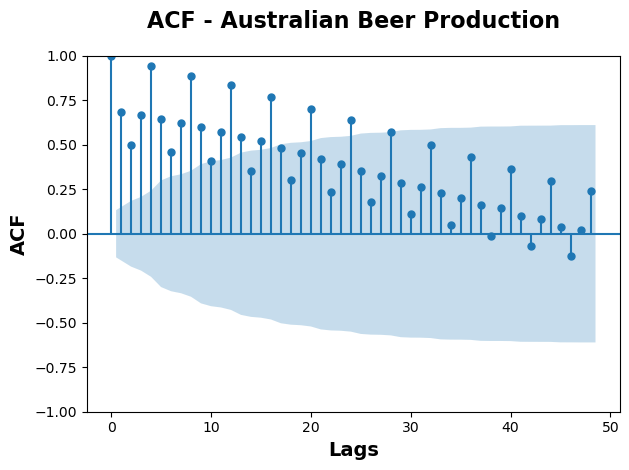

In [6]:
# plot acf
plt.figure(figsize=(18,12))
plot_acf(df.value, lags=4*12)
plt.title('ACF - Australian Beer Production', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Lags', fontsize=14, fontweight='bold')
plt.ylabel('ACF', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1800x1200 with 0 Axes>

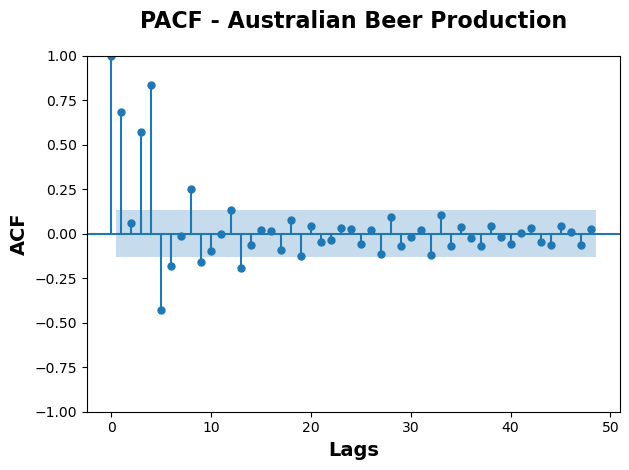

In [7]:
# plot pacf
plt.figure(figsize=(18,12))
plot_pacf(df.value, lags=4*12)
plt.title('PACF - Australian Beer Production', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Lags', fontsize=14, fontweight='bold')
plt.ylabel('ACF', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# autocorrelation (AC) and partial autocorrelation (PAC)  - stationary data 

## check stationarity

The most common test to check if data is stationary is the **Augmented Dickey-Fuller** test (ADF).   
It tests constancy of mean, variance , and covariance over time  

In the ADF test:   
- the **null hypothesis** (H0) us that the time series is not stationary  (p>0.05)  
- the **alternative hypothesis** (H1) is that the time series is stationary  (p<0.05)

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

# test to check if the data are stationary (Augmented Dickey-Fuller)
def check_stationarity(series, name):
    result = adfuller(series.dropna()) 
    print(f'{name}:')
    print(f'  ADF Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.6f}')
    print(f'  Stationary: {result[1] < 0.05}\n')

In [9]:
# Original series
y_beer = df['value']

# Step 1: Quaterly differencing (lag4 for quarterly data)
y_seasonal_diff = y_beer.diff(4).dropna()

# Step 2: First differencing (if needed after seasonal diff)
y_stationary_beer = y_seasonal_diff.diff(1).dropna()

# Check stationarity at each step
check_stationarity(y_beer, 'Original')
check_stationarity(y_seasonal_diff, 'After seasonal diff (lag4)')
check_stationarity(y_stationary_beer, 'After seasonal + first diff')

Original:
  ADF Statistic: -2.6113
  p-value: 0.090677
  Stationary: False

After seasonal diff (lag4):
  ADF Statistic: -2.0197
  p-value: 0.278018
  Stationary: False

After seasonal + first diff:
  ADF Statistic: -7.3529
  p-value: 0.000000
  Stationary: True



## acf and pacf

In [10]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_values = acf(y_stationary_beer)
acf_values

array([ 1.        , -0.6042335 ,  0.03821059,  0.3240282 , -0.41706747,
        0.17598416,  0.0370265 , -0.0119453 , -0.12420803,  0.1282175 ,
       -0.03660837, -0.07700595,  0.09668543,  0.0408631 , -0.16997874,
        0.18572422, -0.05661095, -0.11917797,  0.22711389, -0.17481435,
        0.04391118,  0.05799566, -0.17255574,  0.17852507])

<Figure size 1800x1200 with 0 Axes>

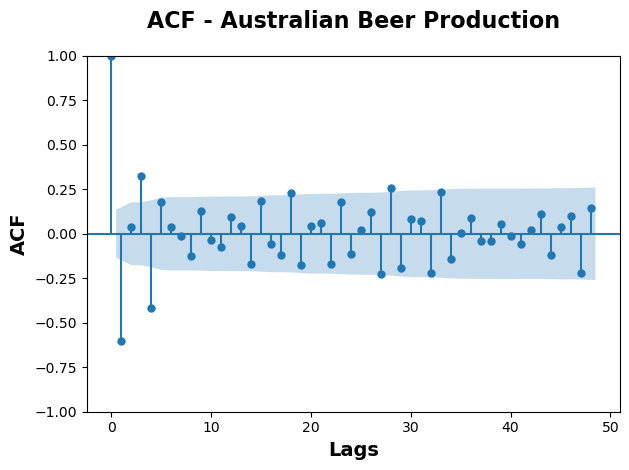

In [11]:
#Plot ACF

plt.figure(figsize=(18,12))
plot_acf(y_stationary_beer, lags=4*12)
plt.title('ACF - Australian Beer Production', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Lags', fontsize=14, fontweight='bold')
plt.ylabel('ACF', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1800x1200 with 0 Axes>

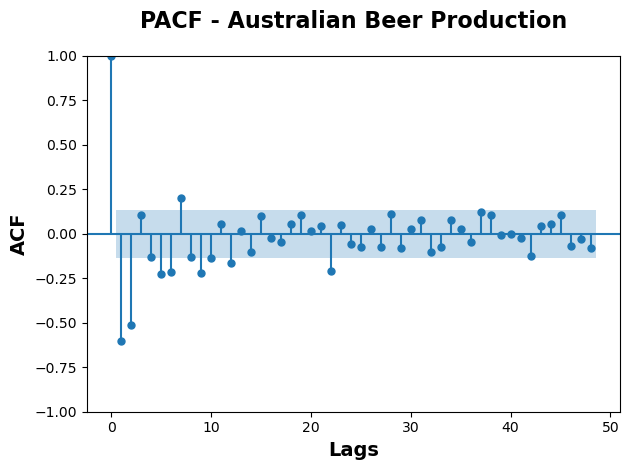

In [12]:
# Plot PACF

plt.figure(figsize=(18,12))
plot_pacf(y_stationary_beer, lags=4*12)
plt.title('PACF - Australian Beer Production', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Lags', fontsize=14, fontweight='bold')
plt.ylabel('ACF', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()